In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy as np
from torch.utils.data import Dataset, DataLoader
import glob
import wandb
import os
import torch.optim as optimizers
import dfs_code
from torch_geometric.data import InMemoryDataset, Data
import pickle
import torch
import torch.nn as nn
import tqdm
import copy
import pandas as pd
import torch.nn.functional as F
import sys
import yaml
import functools
from ml_collections import ConfigDict
sys.path = ['../../src'] + sys.path
from dfs_transformer import DFSCodeSeq2SeqFC, Deepchem2TorchGeometric, Trainer, to_cuda, Enzymes
from graphein.protein.resi_atoms import RESI_THREE_TO_1, AMINO_ACIDS

ImportError: cannot import name 'Enzymes' from 'dfs_transformer' (/home/chrisw/Documents/projects/2023/graph-transformer/notebooks/selfattn/../../src/dfs_transformer/__init__.py)

# download pretrained model

In [ ]:
run = wandb.init(mode="online", 
                 project="pubchem", 
                 entity="dfstransformer", 
                 job_type="inference")

model_at = run.use_artifact("bertloops0.3-10M-nofeats" + ":latest")
model_at = run.use_artifact("rnd2min-1M-nofeats" + ":latest")

model_dir = model_at.download()
run.finish()
features = None #"chemprop"
n_samples = 10
fingerprint = 'min-mean-max-std'
fingerprint = 'cls'
load_flag = True

In [ ]:
with open(model_dir+"/config.yaml") as file:
    config = ConfigDict(yaml.load(file, Loader=yaml.FullLoader))

In [ ]:
device = torch.device('cuda:%d'%config.training.gpu_id if torch.cuda.is_available()  else 'cpu')

In [ ]:
m = config.model

In [ ]:
model = DFSCodeSeq2SeqFC(**m)
if load_flag:
    model.load_state_dict(torch.load(model_dir+'/checkpoint.pt', map_location=device))

In [ ]:
model.to(device)

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("number of trainable parameters %d"%params)

# load dataset

In [ ]:
trainset = pd.read_csv("../../datasets/mymoleculenet/bbbp/0/train.csv")
train_X, train_y = trainset["smiles"].to_numpy(), trainset["target"].to_numpy()
traindata = Deepchem2TorchGeometric(train_X, train_y, loaddir="../../results/mymoleculenet_plus_features/bbbp/1/", features=features)

In [ ]:
import networkx as nx

In [ ]:
def nmatch(n1, n2):
    return n1==n2

def ematch(e1, e2):
    return e1==e2

def edit_distance(g1, g2):
    return nx.graph_edit_distance(g1, g2, node_match=nmatch, edge_match=ematch)


# exact edit distance is too expensive, we use approximate edit distance instead
def edit_distance_approx(g1, g2, nsteps=1):
    iterator = nx.optimize_graph_edit_distance(g1, g2, node_match=nmatch, edge_match=ematch)
    for i in range(nsteps):
        try:
            res = next(iterator)
        except:
            break 
    return res

In [ ]:
G=nx.Graph()
G.add_node(1, id=1)
G.add_node(2, id=5)
G.add_node(3, id=3)
G.add_edge(1, 2, type='a')
G.add_edge(2, 3, type='b')


G2=nx.Graph()
G2.add_node(1, id=1)
G2.add_node(2, id=2)
G2.add_node(3, id=3)
G2.add_edge(1, 2, type='c')
G2.add_edge(2, 3, type='b')

In [ ]:
edit_distance(G,G2)

In [ ]:
def collate_graph(dlist):
    nx_batch = []
    smiles = []
    
    for d in dlist:
        smiles += d.smiles
        graph = nx.Graph()
        for idx, atomic_number in enumerate(d.z.numpy()):
            graph.add_node(idx, atomic_number=atomic_number)
        for edge, edge_type in zip(d.edge_index.numpy().T, np.argmax(d.edge_attr.numpy(), axis=1)):
            graph.add_edge(edge[0], edge[1], bond_type=edge_type)
        nx_batch += [graph]
            
        
    return smiles, nx_batch

In [ ]:
def collate_fn(dlist, n_samples=n_samples):
    node_batch = [] 
    edge_batch = []
    y_batch = []
    code_batch = []
    smiles = []
    
    for d in dlist:
        smiles += d.smiles
        for _ in range(n_samples):
            edge_features = d.edge_features.clone()

            code, index = dfs_code.rnd_dfs_code_from_torch_geometric(d, d.z.numpy().tolist(), 
                                                                     np.argmax(d.edge_attr.numpy(), axis=1).tolist())

            code = torch.tensor(code, dtype=torch.long)
            index = torch.tensor(index, dtype=torch.long)
            code_batch += [code]
            node_batch += [d.node_features.clone()]
            edge_batch += [edge_features]
            y_batch += [d.y.clone()]
            
    y = torch.cat(y_batch).unsqueeze(1)
    return smiles, code_batch, node_batch, edge_batch, y

In [ ]:
trainloaderg = DataLoader(traindata, batch_size=1, shuffle=False, pin_memory=False, 
                         collate_fn=collate_graph)
trainloader = DataLoader(traindata, batch_size=1, shuffle=False, pin_memory=False, 
                         collate_fn=collate_fn)

In [ ]:
graphs = {''.join(d[0]): d[-1] for d in trainloaderg}

In [ ]:
graphs = {key: value[0] for key, value in graphs.items()}

In [20]:
#'CCN(CC)CCNC(=O)c1cc(Cl)cc(Cl)c1OC'

In [21]:
reference = graphs['CCN(CC)CCNC(=O)c1cc(Cl)cc(Cl)c1OC']

from rdkit import Chem
m1 = Chem.MolFromSmiles('CCN(CC)CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)C=CC4(C)C3C(O)CC21C')

Chem.Draw.MolToMPL(m1)

In [22]:
edit_distances = {}
for smiles, graph in tqdm.tqdm(graphs.items()):
    edit_distances[smiles] = edit_distance_approx(reference, graph, 1)  

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1567/1567 [00:13<00:00, 114.69it/s]


In [23]:
from matplotlib import pyplot as plt

(array([  2.,  11., 344., 684., 276., 144.,  51.,  20.,  10.,   8.,  11.,
          1.,   0.,   0.,   2.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,
          0.,   1.]),
 array([  0.,  11.,  22.,  33.,  44.,  55.,  66.,  77.,  88.,  99., 110.,
        121., 132., 143., 154., 165., 176., 187., 198., 209., 220., 231.,
        242., 253., 264.]),
 <BarContainer object of 24 artists>)

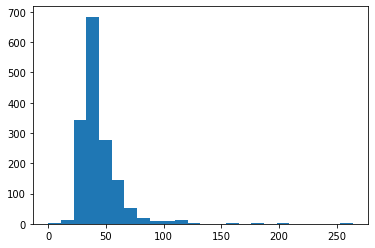

In [24]:
plt.hist(list(edit_distances.values()), bins='rice')

In [25]:
encodings = {}
encodings2 = {}
iterator = iter(trainloader)
for d in tqdm.tqdm(trainloader):
    d = next(iterator)
    smiles = ''.join(d[0])
    d = d[1:]
    d = [to_cuda(dd, device) for dd in d]
    encodings[smiles] = model.encode(*d[:-1], fingerprint).detach().cpu().numpy()
    dfs1, dfs2, atm1, atm2, bnd = model(*d[:-1])
    enc2 = torch.cat((dfs1.mean(dim=0), dfs2.mean(dim=0), atm1.mean(dim=0), atm2.mean(dim=0), bnd.mean(dim=0)), dim=1)
    encodings2[smiles] = enc2.detach().cpu().numpy()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1631/1631 [00:32<00:00, 49.66it/s]


In [26]:
distances = {}

In [27]:
ref_enc = encodings['CCN(CC)CCNC(=O)c1cc(Cl)cc(Cl)c1OC']
for smiles, enc in tqdm.tqdm(encodings.items()):
    dists = np.linalg.norm(ref_enc - enc, axis=1)
    distances[smiles] = np.mean(dists)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1567/1567 [00:00<00:00, 33890.09it/s]


In [28]:
edit_dists = edit_distances.values()
transf_dists = distances.values() 

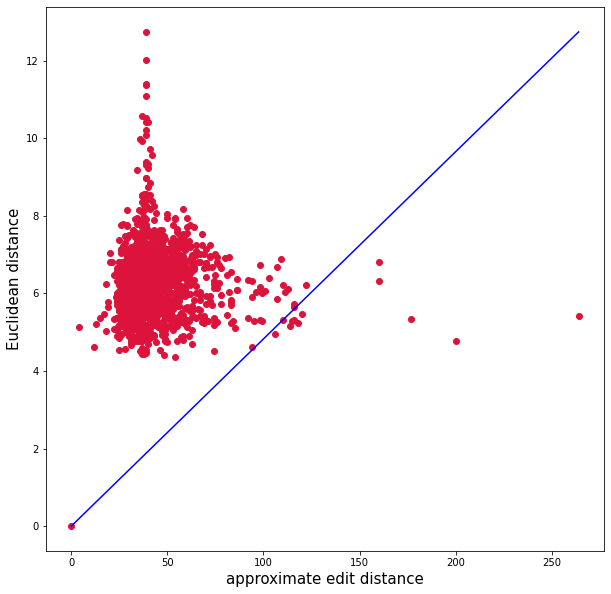

In [29]:
plt.figure(figsize=(10,10))
plt.scatter(edit_dists, transf_dists, c='crimson')

plt.plot([0, max(edit_dists)], [0, max(transf_dists)], 'b-')
plt.xlabel('approximate edit distance', fontsize=15)
plt.ylabel('Euclidean distance', fontsize=15)
plt.show()

# what happens along an edit path

In [30]:
print(np.unique(list(edit_distances.values())))
for smiles, dist in edit_distances.items():
    if dist == 12:
        print(smiles)
        break

[  0.   4.  12.  13.  15.  17.  18.  19.  20.  21.  22.  23.  24.  25.
  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.
  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.
  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.
  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  80.  81.  82.
  83.  84.  85.  86.  92.  94.  95.  96.  98.  99. 101. 103. 106. 107.
 109. 110. 111. 113. 114. 115. 116. 118. 120. 122. 160. 177. 200. 264.]
CCN(CC)CCNC(=O)COc1ccc(Cl)cc1


paths, cost = nx.optimal_edit_paths(reference, graphs['CCN(CC)CCNC(=O)COc1ccc(Cl)cc1'])